<a href="https://colab.research.google.com/github/matthiasdellago/nanoGPT/blob/master/exploring_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-03-07 11:28:35--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2023-03-07 11:28:35 (53.6 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [3]:
!pip install icecream

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


0.008897 M parameters
step 0: train loss 4.3390, val loss 4.3295
recording:
recording:
recording:
recording:

p'olRmPgVUz-BgQoQgjcE!Ta,ZauehsdPrsbab.jSxsIx'JTaPolOm?CGuH3p$eySMqjTB'rD3O
qdQ?ye!sFi,tWKgeev.:uejqCeyYqrSw&ccZnVDdCvKn'YHGeQ'YLtFHlv,YAhCAv,pIcQjysBcaCc'qGhChyvp3UViYhaB'smO;KO?e'WngaVjjScOf!sQnvPLDMZa:wesOfbrzw'rNDeqQSUvEalgSWesoBhaC
gis?aQm,ul'Fe-LQil,.y&yYEmYPbAcisdnUmfnBNx!LPPdop!s.HqIjTSmrmO$wNFhrxusg3g.sQv!CzsvqyFswelo,eCew?t$'ZHvm:jwN:,W z sewThm!KZNiuYvzxUuuZqQRHPxicc$'cvKRqAjf.s$RobN!qJvoWJOH;.EMaaQmOyeSHqQ3DMbKoW.X&.TfrDOwuOIuc'esOZPjv!oQ'lG&poK&3&'uV&'opXaLs.que$Kz'lFPzC&eFOHysv
nq!!GfTalODg.qBUzXANJsRPs-Lsrwg?B'hRbyyStMrqA:Of''DkNEeNHu
vOAwCHj o&QfQo?EFjwCsDqC$Yvztrs!AhFT?u;bVIsJx'q:rZl:JUQLm;Utn$qe sT'YugNBot,OThoGJuXl sCgUvmiLSjBbIUQgSEl3$XWszYCyPuumDDC$,GurPn.:KoK.h?wHjVHzvu,FFyUD''FXwH uuQ! cjqhdgf,P'$UO
-OI,wtFeFO?yOmkK YuWE'c!iODqc-&Oeyusi;HNJ:qZe:uMyeSRQumD!$q.FTKjBK'CDCnW$ YvMAOpAyyWKbKo:SqC3I!MA$FvaFev-iu
eryjv:h!Os oeRL!s&evwukeePs&sm,TAN!e,bicJOFc,yn:Jz

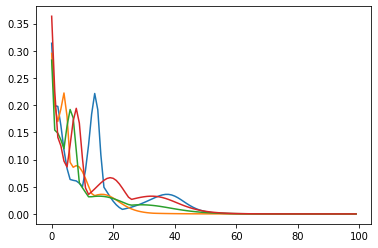

In [40]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from icecream import ic
import matplotlib.pyplot as plt


# hyperparameters
batch_size = 4#16 # how many independent sequences will we process in parallel?
block_size = 16#32 # what is the maximum context length for predictions?
max_iters = 1#5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 16#64
n_head = 2#4
n_layer = 2#4
dropout = 0.0
att_iterations = 100
testing = False
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """
        # make an extra forward-like function that just computes and returns the iterated attention.
        # Let's do some statistics on the attrocors in the attention layer.
        # The plan is:
        # 1. apply the attention operation to each attention vector a few times
        # 2. calculate the distances amongst all the attracted (hopefully converged vectors)
        # 3. Create a histogram of all the distances.
        # Expectation: Some distribution with a peak around (?) the average distance on
        # the unit sphere in n dimensions 
        # (https://math.stackexchange.com/questions/2366580/whats-the-average-euclidian-distance-between-two-points-on-a-unit-n-sphere) 
        # and maybe a peak at 0.
        # If there are entries close to 0 then not every attention vector gets its own attractor!
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
        
        self.record = False

    def set_record(self, record):
        self.record = record

    @torch.no_grad()
    def attention(self, frame, start, values):
        # another way of computing attention:
        # instead of attention Softmax(<Kx, Qx>/sqrt(d))*Vx
        # we compute Softmax(<Q^TKx, x>/sqrt(d))*Vx
        # computationally this is less efficient and conditioned.
        # The andvantage is that this is conceptually closer to an intuitive understanding
        # of attention as a vector field.
        # If we define our attention frame=x,
        # the points to be subjected to the attention opration as start=Q^TKx,
        # and the vectors to be weightes as values=Vx, we recover standard attention, (up to a conditioning error).

        B,T,C = start.shape
        
        #compute scalar product 
        wei = start @ frame.transpose(-2,-1)
        
        wei = wei * C**-0.5 # normalise by dimension
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        # perform the weighted aggregation of the values
        out = wei @ values # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei * C**-0.5 # normalise by dimension
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        #wei = self.dropout(wei) # This might be important???!!!
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)

        #experiment section: won't affect output and gradients
        with torch.no_grad():
          #test attention implementation
          if testing:
            # comute the same thing with attention, to check implementation:
            # apply all the key and query matrix to one side of the scalar product
            start = x @ self.query.weight.T @ self.key.weight
            att_out = self.attention(frame=x, start=start, values=self.value(x))
            #check if you get the same thing. If not throw error.
            if not torch.allclose(att_out,out,atol=1e-06):
              ic(att_out)
              ic(out)
              ic(torch.eq(att_out, out))
              raise Exception("Attention not implemented correctly!")

          if self.record:
            print("recording:")
            # iterate attention:
            # simple self attention with KQ but no V Matrix
            # we need to plug in the starting vectors that are created by K and Q^T. They're not x!!
            start = x @ self.query.weight.T @ self.key.weight
            positions = self.attention(frame=x,start=start,values=x)
            
            # let the  attention do its thing and it iterate a few times.
            # we expect fast convergence due to exponentials.
            
            # track the delta to see how fast they converge.
            max_delta = []
            
            for _ in range(att_iterations):
              new_positions = self.attention(frame=x,start=positions,values=x)
              #let's see if they converged: do done more iteration and see how much they move
              delta=torch.subtract(positions, new_positions).abs()
              max_delta.append(delta.max())
              positions = new_positions
            
            # show convergence!
            plt.plot(max_delta)
            
            #let's see if they converged: do done more iteration and see how much they move
            #diff=torch.subtract(start, self.attention(frame=x,start=position,values=x))
            #print(diff.max())
            #histo=torch.histogram(diff, bins=100)
            #print(histo.hist)
            # normalize histogram
            # hist = histo.hist.div(histo.hist.sum())
            #plt.bar(histo.bin_edges[:-1], histo.hist, align='edge', alpha=.4) # popping the last element from bin edges is an ugly hack. fix later

        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

        self.record = False

    def set_record(self, record):
        self.record = record
        for head in self.heads:
          head.set_record(record)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

        self.record = False

    def set_record(self, record):
        self.record = record
        self.sa.set_record(record)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
        self.record = False

    def set_record(self, record):
        self.record = record
        for block in self.blocks:
          block.set_record(record)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for i in range(max_new_tokens):
            if i == max_new_tokens-1:
              self.set_record(True)
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model

m.set_record(False)
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))
